# EDA
회귀분석을 할 때 다중공선성이 발생하면, 데이터 분석의 신뢰성이나 예측 정확도를 떨어뜨린다. 이러한 문제를 하기 위한 방법 중 하나로 데이터 선정/전처리 과정에서 "변수선택"이 매우 중요하다. ADP 에서 종종 출제되는 가변수를 만드는 전처리 및 다중공선성 확인 및 정규성을 확인해보자
- 참고 데이터 : 도요타코롤라

## 범주형 파생변수 만들기

In [176]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

# 데이터 불러오기

corolla = pd.read_csv("./ToyotaCorolla.csv")
corolla.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1436 entries, 0 to 1435
Data columns (total 37 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Id                1436 non-null   int64 
 1   Model             1436 non-null   object
 2   Price             1436 non-null   int64 
 3   Age_08_04         1436 non-null   int64 
 4   Mfg_Month         1436 non-null   int64 
 5   Mfg_Year          1436 non-null   int64 
 6   KM                1436 non-null   int64 
 7   Fuel_Type         1436 non-null   object
 8   HP                1436 non-null   int64 
 9   Met_Color         1436 non-null   int64 
 10  Automatic         1436 non-null   int64 
 11  cc                1436 non-null   int64 
 12  Doors             1436 non-null   int64 
 13  Cylinders         1436 non-null   int64 
 14  Gears             1436 non-null   int64 
 15  Quarterly_Tax     1436 non-null   int64 
 16  Weight            1436 non-null   int64 
 17  Mfr_Guarantee 

- 적절한 범주형 변수를 찾아야 함 

In [201]:
# Fuel_Type 변수 확인

corolla.Fuel_Type.unique()

array(['Diesel', 'Petrol', 'CNG'], dtype=object)

- 연료타입이 3가지 종류가 있는 것으로 확인되어 이를 데이터 분석을 위한 수치화를 진행할 필요가 있어보인다.

In [177]:
# 가변수 생성

nCar = corolla.shape[0]
nVar = corolla.shape[1]

dummy_p = np.repeat(0,nCar)
dummy_c = np.repeat(0,nCar)
dummy_d = np.repeat(0,nCar)

# boolean 인덱싱을 통해 boolean index 행렬 생성

p_idx = np.array(corolla.Fuel_Type == "Petrol")
d_idx = np.array(corolla.Fuel_Type == "Diesel")
c_idx = np.array(corolla.Fuel_Type == "CNG")


# boolean index 행렬을 사용하여 가변수에 대입 ( True = 1, False = 0 )
dummy_p[p_idx] = 1
dummy_d[d_idx] = 1
dummy_c[c_idx] = 1


# 행렬로 존재하는 가변수 -> 데이터프레임으로 전환
Fuel = pd.DataFrame({"Petrol" : dummy_p, "Diesel" : dummy_d, "CNG" : dummy_c})


# 불필요한 변수 삭제 및 가변수 붙이기
corolla_ = corolla.drop(["Id","Model","Fuel_Type"], axis = 1, inplace = False)
mlr_data = pd.concat([corolla_,Fuel],1)


# bias를 위한 상수항 추가
mlr_data = sm.add_constant(mlr_data, has_constant = "add")
mlr_data

C:\Users\David\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:29: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only


,const,Price,Age_08_04,Mfg_Month,Mfg_Year,KM,HP,Met_Color,Automatic,cc,...,Radio,Mistlamps,Sport_Model,Backseat_Divider,Metallic_Rim,Radio_cassette,Tow_Bar,Petrol,Diesel,CNG
0,1.0,13500,23,10,2002,46986,90,1,0,2000,...,0,0,0,1,0,0,0,0,1,0
1,1.0,13750,23,10,2002,72937,90,1,0,2000,...,0,0,0,1,0,0,0,0,1,0
2,1.0,13950,24,9,2002,41711,90,1,0,2000,...,0,0,0,1,0,0,0,0,1,0
3,1.0,14950,26,7,2002,48000,90,0,0,2000,...,0,0,0,1,0,0,0,0,1,0
4,1.0,13750,30,3,2002,38500,90,0,0,2000,...,0,1,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1431,1.0,7500,69,12,1998,20544,86,1,0,1300,...,0,1,1,1,0,0,0,1,0,0
1432,1.0,10845,72,9,1998,19000,86,0,0,1300,...,0,0,1,1,0,0,0,1,0,0
1433,1.0,8500,71,10,1998,17016,86,0,0,1300,...,0,0,0,1,0,0,0,1,0,0
1434,1.0,7250,70,11,1998,16916,86,1,0,1300,...,0,0,0,1,0,0,0,1,0,0


## 회귀분석

In [6]:
# 종속변수, 설명변수 준비

feature_columns = mlr_data.columns.difference(["Price"]) # Target column 빼기

X = mlr_data[feature_columns]
y = mlr_data.Price

train_x, test_x, train_y, test_y = train_test_split(X,y, train_size = 0.7, test_size = 0.3)

print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

(1005, 37) (431, 37) (1005,) (431,)


In [7]:
# train & 회귀모델 적합

full_model = sm.OLS(train_y,train_x)
fitted_full_model = full_model.fit()

fitted_full_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     288.0
Date:                Tue, 29 Aug 2023   Prob (F-statistic):               0.00
Time:                        07:14:12   Log-Likelihood:                -8453.4
No. Observations:                1005   AIC:                         1.697e+04
Df Residuals:                     971   BIC:                         1.714e+04
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
ABS               -209.1348    135.532     -1.543      0.123    -475.104      56.834
Age_08_04         -121.4503      4.206    -28.872      0.000    -129.705    -113.196
Airbag_1           184.6335    270.467      0.683      0.495    -346.134     715.401
Airbag_2           -76.3266    139.305     -0.548      0.584    -349.701     197.048
Airco              166.1030     95.305      1.743      0.082     -20.924     353.131
Automatic          431.2130    159.784      2.699      0.007     117.652     744.774
Automatic_airco   2399.4228    198.598     12.082      0.000    2009.692    2789.153
BOVAG_Guarantee    353.2689    131.141      2.694      0.007      95.917     610.621
Backseat_Divider  -312.7795    134.836     -2.320      0.021    -577.383     -48.176
Boardcomputer     -337.2981    125.746     -2.682      0.007    -584.063     -90.533
CD_Player          294.0563    105.520      2.787      0.005      86.982     501.130
CNG              -1105.7947    236.346     -4.679      0.000   -1569.602    -641.987
Central_Lock        97.4224    165.192      0.590      0.555    -226.751     421.596
Cylinders           -0.0334      0.002    -14.757      0.000      -0.038      -0.029
Diesel             161.8499    194.900      0.830      0.407    -220.624     544.324
Doors               26.0380     42.259      0.616      0.538     -56.891     108.967
Gears               69.1401    196.987      0.351      0.726    -317.430     455.710
Guarantee_Period    56.8111     15.211      3.735      0.000      26.961      86.661
HP                  22.9470      3.658      6.273      0.000      15.768      30.126
KM                  -0.0156      0.001    -11.109      0.000      -0.018      -0.013
Met_Color          -15.2726     79.940     -0.191      0.849    -172.148     141.603
Metallic_Rim       246.2389    100.363      2.453      0.014      49.285     443.193
Mfg_Month          -98.9174     10.993     -8.998      0.000    -120.490     -77.344
Mfg_Year             1.6271      0.826      1.970      0.049       0.006       3.248
Mfr_Guarantee      249.2004     77.981      3.196      0.001      96.169     402.232
Mistlamps           37.4949    117.062      0.320      0.749    -192.229     267.218
Petrol             943.9365    199.032      4.743      0.000     553.354    1334.519
Power_Steering      17.1144    303.273      0.056      0.955    -578.031     612.260
Powered_Windows    244.0205    164.575      1.483      0.138     -78.944     566.985
Quarterly_Tax       14.8763      1.981      7.508      0.000      10.988      18.764
Radio             -681.9936    810.016     -0.842      0.400   -2271.578     907.591
Radio_cassette     712.4387    812.196      0.877      0.381    -881.423    2306.300
Sport_Model        267.3095     94.393      2.832      0.005      82.072     452.547
Tow_Bar           -161.

## 다중공산성 확인

In [ ]:
# VIF를 통한 다중공선성 확인

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(mlr_data.values, i) for i in range(mlr_data.shape[1])]
vif["features"] = mlr_data.columns
vif[['features','VIF Factor']].sort_values('VIF Factor',ascending=False)

C:\Dev\Miniconda\lib\site-packages\statsmodels\regression\linear_model.py:1736: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\Dev\Miniconda\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,features,VIF Factor
37,CNG,inf
36,Diesel,inf
2,Age_08_04,inf
3,Mfg_Month,inf
4,Mfg_Year,inf
35,Petrol,inf
28,Radio,62.344621
33,Radio_cassette,62.172860
1,Price,10.953474
13,Quarterly_Tax,5.496805


## 잔차 및 정규성 확인

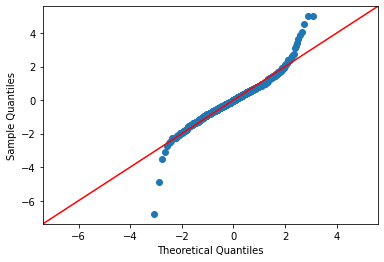

In [9]:
# 학습데이터의 잔차 확인
res = fitted_full_model.resid

# q-q plot을 통한 잔차의 정규분포 확인
fig = sm.qqplot(res,fit = True, line = '45')

 q-q plot은 잔차의 정규성을 확인할 때 쓰는 그래프 중 하나로, statsmodels.api 라이브러리 내에 존재한다. 이 q-q plot은 y=x의 형태를 띄어야 정규성을 보이는 것이다. 위의 그래프를 보면 잔차가 완전한 정규성을 보이지 않는 것을 확인할 수 있다. 하지만, 실제데이터는 잔차가 완전한 정규성을 띄는 것을 확인하기 힘들다. 보통 위의 그래프처럼 실제에서도 꼬리부분의 값을이 정규성을 띄지 않는 경우가 많다. 그래도 위의 그래프는 꼬리부분 약간의 데이터를 제외하고 정규성을 띄고 있다고 판단되어 양호하다는 판단이 가능하다.

Text(0, 0.5, 'Residual')

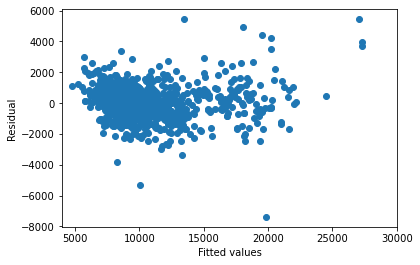

In [11]:
# 잔차패턴 확인

pred_y = fitted_full_model.predict(train_x)

import matplotlib.pyplot as plt

plt.scatter(pred_y, res)

plt.xlim(4000,30000)
plt.xlabel('Fitted values')
plt.ylabel('Residual')

 위의 그래프는 모든 변수를 사용해 학습된 모델의 예측값과 잔차간의 상관관계를 확인하기 위해 나타낸 산점도이다. 이를 보면 특별한 경향이 발견되지 않으므로 잔차가 균등하게 나와있다고 판단가능하다. 

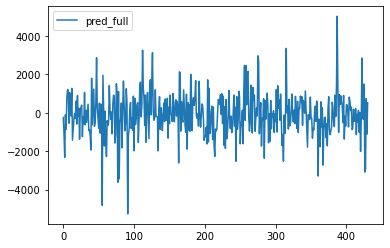

In [12]:
# 검증데이터에 대한 예측

pred_y2 = fitted_full_model.predict(test_x)

# 예측데이터 잔차

plt.plot(np.array(test_y - pred_y2), label = "pred_full")
plt.legend()
plt.show()

테스트값에 대한 잔차를 확인하면, 하나의 수치를 제외하면 균등하게 분포되어있음

In [13]:
#MSE 구하기

from sklearn.metrics import mean_squared_error

mean_squared_error(y_true = test_y, y_pred = pred_y2)

1315085.7258945287

이러한 과정으로 데이터를 확인하고 변수를 제거해야하는지 확인하는 작업이 사전에 필요하다. 그리고 다중공선성/과적합 등 문제가 발생하면 변수를 가공하고, 범주형 변수는 가변수생성을 통해 추가적인 변수로 변환할 필요가 있다. 이 과정 후에 변수선택법을 적용하여 변수를 선택하고 축소하는 과정이 이어진다.  

# 변수선택법

In [15]:
import time
import itertools

#변수선택을 통해 형성한 모델의 AIC를 구하는 함수
# AIC가 낮을 수록 모델이 좋다고 평가된다.
def processSubset(X,y,feature_set):
    model = sm.OLS(y,X[list(feature_set)]) # Modeling
    regr = model.fit() # model fitting
    AIC = regr.aic # model's AIC
    return {"model" : regr, "AIC" : AIC}

# getBest : 가장 낮은 AIC를 가지는 모델을 선택하고 저장하는 함수
def getBest(X,y,k):
    tic = time.time() # 시작 시간
    results = [] # 결과 저장 공간
    
    # 각 변수 조합을 고려한 경우의수
    for combo in itertools.combinations(X.columns.difference(['const']),k):
        combo = (list(combo)+['const']) # 상수항을 추가하여 combo를 결성
        results.append(processSubset(X,y,feature_set = combo)) # 모델링된것을 저장
                              
    models = pd.DataFrame(results) # 데이터프레임으로 모델결과 변환
    best_model = models.loc[models['AIC'].argmin()] # argmin은 최소값의 인덱스를 뽑는 함수
    toc = time.time() # 종료 시간
    print("Processed", models.shape[0], "models on", k, "predictors in",(toc - tic),"seconds.")
    return best_model

getBest(X=train_x, y = train_y, k=2)

Processed 630 models on 2 predictors in 1.134995460510254 seconds.


model    <statsmodels.regression.linear_model.Regressio...
AIC                                           17499.544708
Name: 211, dtype: object

##  전진선택법

In [65]:
def forward(X,y,predictors):
    # predictor - 현재 선택되어있는 변수
    # 데이터 변수들이 미리정의된 predictors에 있는지 없는지 확인 및 분류
    remaining_predictors = [p for p in X.columns.difference(['const']) if p not in predictors]
    tic = time.time()
    results = []
    for p in remaining_predictors :
        results.append(processSubset(X=X,y=y,feature_set=predictors+[p]+['const']))

    # 데이터프레임으로 변환
    models = pd.DataFrame(results)

    # AIC가 가장 낮은 것을 선택
    best_model = models.loc[models['AIC'].argmin()]
    
    toc = time.time()
    # print(best_model)
    print(f"Processed {models.shape[0]}, models on {len(predictors)+1},predictors in{(toc-tic):.3f}")
    print(f"Selected predictors: {best_model['model'].model.exog_names} \nAIC: {best_model[1]:.3f}")
    print()
    return best_model

def forward_model(X,y):
    Fmodels = pd.DataFrame(columns=["AIC","model"])
    tic = time.time()
    predictors = []

    # 변수 1~10개 : 0-9 -> 1-10
    for i in range(1, len(X.columns.difference(['const']))+1):
        Forward_result = forward(X=X , y=y, predictors=predictors)
        if i > 1 :
            if Forward_result["AIC"] > Fmodel_before:
                break
        Fmodels.loc[i] = Forward_result
        predictors = Fmodels.loc[i]["model"].model.exog_names
        Fmodel_before = Fmodels.loc[i]["AIC"]
        predictors = [k for k in predictors if k != 'const']
    toc = time.time()
    print("Total elapsed time:",(toc-tic), "seconds.")

    return (Fmodels['model'][len(Fmodels['model'])])

In [ ]:
Forward_best_model = forward_model(X=train_x, y=train_y)

- 변수를계속 추가하며 AIC가 증가하는 경우가 생기면, 이전 모델을 선택하는 학습과정을 진행한다

In [66]:
Forward_best_model.aic

16959.00706023506

In [67]:
Forward_best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     415.5
Date:                Tue, 29 Aug 2023   Prob (F-statistic):               0.00
Time:                        07:32:39   Log-Likelihood:                -8455.5
No. Observations:                1005   AIC:                         1.696e+04
Df Residuals:                     981   BIC:                         1.708e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Mfg_Year          1457.5891     49.114     29.678      0.000    1361.208    1553.970
Automatic_airco   2402.2817    182.567     13.158      0.000    2044.016    2760.548
Weight               9.8614      1.142      8.637      0.000       7.621      12.102
KM                  -0.0155      0.001    -11.141      0.000      -0.018      -0.013
HP                  21.9823      3.542      6.206      0.000      15.032      28.933
Central_Lock       116.9404    160.998      0.726      0.468    -199.000     432.880
Quarterly_Tax       14.7153      1.920      7.666      0.000      10.948      18.482
Petrol           -7.287e+05   2.45e+04    -29.778      0.000   -7.77e+05   -6.81e+05
Guarantee_Period    59.0242     14.826      3.981      0.000      29.930      88.118
Metallic_Rim       263.4380     93.367      2.822      0.005      80.217     446.659
Mfr_Guarantee      244.4188     76.659      3.188      0.001      93.983     394.854
Diesel           -7.295e+05   2.45e+04    -29.804      0.000   -7.78e+05   -6.82e+05
Boardcomputer     -334.2517    123.482     -2.707      0.007    -576.572     -91.932
BOVAG_Guarantee    380.0324    129.019      2.946      0.003     126.848     633.217
CD_Player          265.6198    101.702      2.612      0.009      66.042     465.197
Mfg_Month           21.3081     10.714      1.989      0.047       0.284      42.332
Automatic          387.8602    156.387      2.480      0.013      80.969     694.752
ABS               -222.7873    104.094     -2.140      0.033    -427.061     -18.514
Sport_Model        254.1427     88.623      2.868      0.004      80.231     428.055
Backseat_Divider  -311.1664    120.477     -2.583      0.010    -547.589     -74.744
Airco              165.5736     91.564      1.808      0.071     -14.111     345.258
Tow_Bar           -154.1662     81.231     -1.898      0.058    -313.572       5.240
Powered_Windows    250.7068    162.230      1.545      0.123     -67.650     569.064
CNG              -7.308e+05   2.45e+04    -29.822      0.000   -7.79e+05   -6.83e+05
const            -2.189e+06   7.34e+04    -29.803      0.000   -2.33e+06   -2.04e+06
==============================================================================
Omnibus:                      112.461   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              881.914
Skew:                           0.116   Prob(JB):                    3.12e-192
Kurtosis:                       7.583   Cond. No.                     2.67e+20
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 8.21e-29. This might indicate that there are
strong multicollinearity problems or that the design 

## 후진제거법

In [92]:
def backward(X,y,predictors):
    tic = time.time()
    results = []
    for combo in itertools.combinations(predictors, len(predictors) - 1):
        results.append(processSubset(X=X,y=y,feature_set=list(combo)+['const']))
    models = pd.DataFrame(results)
    # 가장 낮은 AIC를 가진 모델을 선택
    best_model = models.loc[models['AIC'].argmin()]
    toc = time.time()
    
    print(f"Processed {models.shape[0]} models on {len(predictors) - 1} predictors in {(toc-tic):.3f}")
    print(f'Selected predictors: {best_model["model"].model.exog_names} \n AIC: {best_model[1]:.3f}')
    print()
    
    return best_model

def backward_model(X,y) :
    Bmodels = pd.DataFrame(columns=["AIC","model"], index = range(1,len(X.columns)))
    tic = time.time()
    predictors = X.columns.difference(['const'])
    Bmodel_before = processSubset(X, y, predictors)['AIC']
    while (len(predictors) > 1):
        Backward_result = backward(X=train_x, y= train_y,predictors=predictors)
        if Backward_result['AIC'] > Bmodel_before : break
        Bmodels.loc[len(predictors) -1] = Backward_result
        predictors = Bmodels.loc[len(predictors) - 1]['model'].model.exog_names
        Bmodel_before = Backward_result["AIC"]
        predictors = [k for k in predictors if k != 'const']

    toc = time.time()
    print("Total elapsed time:",(toc-tic),"seconds.")
    return Bmodels["model"].dropna().iloc[0]

In [ ]:
Backward_best_model = backward_model(X=train_x, y= train_y)

In [94]:
Backward_best_model.aic

16957.54740210653

In [95]:
Backward_best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     434.6
Date:                Tue, 29 Aug 2023   Prob (F-statistic):               0.00
Time:                        07:49:22   Log-Likelihood:                -8455.8
No. Observations:                1005   AIC:                         1.696e+04
Df Residuals:                     982   BIC:                         1.707e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
ABS               -223.5094    104.065     -2.148      0.032    -427.724     -19.295
Airco              173.5813     90.876      1.910      0.056      -4.753     351.915
Automatic          387.3712    156.348      2.478      0.013      80.557     694.185
Automatic_airco   2402.0330    182.522     13.160      0.000    2043.854    2760.212
BOVAG_Guarantee    378.1191    128.961      2.932      0.003     125.049     631.189
Backseat_Divider  -310.4403    120.444     -2.577      0.010    -546.798     -74.083
Boardcomputer     -334.4778    123.452     -2.709      0.007    -576.738     -92.217
CD_Player          269.3438    101.548      2.652      0.008      70.068     468.619
Cylinders        -6.864e+05    2.3e+04    -29.807      0.000   -7.32e+05   -6.41e+05
Diesel            1226.1547    375.588      3.265      0.001     489.107    1963.202
Guarantee_Period    59.8978     14.773      4.054      0.000      30.907      88.889
HP                  22.0835      3.538      6.241      0.000      15.140      29.027
KM                  -0.0155      0.001    -11.138      0.000      -0.018      -0.013
Metallic_Rim       264.3685     93.335      2.832      0.005      81.209     447.528
Mfg_Month           20.9865     10.702      1.961      0.050      -0.015      41.988
Mfg_Year          1456.3956     49.075     29.677      0.000    1360.092    1552.699
Mfr_Guarantee      245.5440     76.625      3.204      0.001      95.176     395.912
Petrol            2082.0000    379.333      5.489      0.000    1337.603    2826.397
Powered_Windows    349.6680     88.046      3.971      0.000     176.889     522.447
Quarterly_Tax       14.7169      1.919      7.668      0.000      10.951      18.483
Sport_Model        256.4151     88.546      2.896      0.004      82.653     430.177
Tow_Bar           -153.6848     81.209     -1.892      0.059    -313.047       5.677
Weight               9.8772      1.141      8.654      0.000       7.638      12.117
const            -1.716e+05   5757.312    -29.807      0.000   -1.83e+05    -1.6e+05
==============================================================================
Omnibus:                      112.135   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              874.553
Skew:                           0.117   Prob(JB):                    1.24e-190
Kurtosis:                       7.564   Cond. No.                     7.28e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.1e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## 단계적선택법

In [153]:
def Stepwise_model(X,y):
    Stepmodels = pd.DataFrame(columns = ["AIC","model"])
    tic = time.time()
    predictors = []    
    # 변수 1~10개 0-9 -> 1-10
    for i in range(len(X.columns.difference(['const']))) :
        Forward_result = forward(X=X, y=y, predictors = predictors) # constant added
        print('forward')
        Stepmodels.loc[i] = Forward_result
        predictors = Stepmodels.loc[i]['model'].model.exog_names
        
        predictors = [k for k in predictors if k != 'const']
        Backward_result = backward(X=X, y=y, predictors = predictors)
        Smodel_before = Stepmodels.loc[i]["AIC"]
        
        if Backward_result["AIC"] < Smodel_before:
            Stepmodels.loc[i] = Backward_result
            predictors = Stepmodels.loc[i]["model"].model.exog_names
            Smodel_before = Stepmodels.loc[i]["AIC"]
            predictors = [k for k in predictors if k != "const"]
            print('backward')
        if Stepmodels.loc[i]["AIC"] > Smodel_before:
            break
        else :            Smodel_before = Stepmodels.loc[i]["AIC"]
            
    toc = time.time()
    print("Total elapsed time:",(toc-tic),"seconds.")
    return (Stepmodels["model"][len(Stepmodels["model"])-1])

In [ ]:
Stepwise_best_model = Stepwise_model(X=train_x, y= train_y)

In [163]:
Stepwise_best_model.aic

16957.547402106567

In [164]:
Stepwise_best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     434.6
Date:                Tue, 29 Aug 2023   Prob (F-statistic):               0.00
Time:                        08:30:36   Log-Likelihood:                -8455.8
No. Observations:                1005   AIC:                         1.696e+04
Df Residuals:                     982   BIC:                         1.707e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Mfg_Year          1456.3956     49.075     29.677      0.000    1360.092    1552.699
Automatic_airco   2402.0330    182.522     13.160      0.000    2043.854    2760.212
Weight               9.8772      1.141      8.654      0.000       7.638      12.117
KM                  -0.0155      0.001    -11.138      0.000      -0.018      -0.013
HP                  22.0835      3.538      6.241      0.000      15.140      29.027
Quarterly_Tax       14.7169      1.919      7.668      0.000      10.951      18.483
Petrol            -5.51e+04   1878.033    -29.341      0.000   -5.88e+04   -5.14e+04
Guarantee_Period    59.8978     14.773      4.054      0.000      30.907      88.889
Metallic_Rim       264.3685     93.335      2.832      0.005      81.209     447.528
Mfr_Guarantee      245.5440     76.625      3.204      0.001      95.176     395.912
Diesel           -5.596e+04   1884.956    -29.687      0.000   -5.97e+04   -5.23e+04
Boardcomputer     -334.4778    123.452     -2.709      0.007    -576.738     -92.217
BOVAG_Guarantee    378.1191    128.961      2.932      0.003     125.049     631.189
CD_Player          269.3438    101.548      2.652      0.008      70.068     468.619
Mfg_Month           20.9865     10.702      1.961      0.050      -0.015      41.988
Automatic          387.3712    156.348      2.478      0.013      80.557     694.185
ABS               -223.5094    104.065     -2.148      0.032    -427.724     -19.295
Sport_Model        256.4151     88.546      2.896      0.004      82.653     430.177
Backseat_Divider  -310.4403    120.444     -2.577      0.010    -546.798     -74.083
Airco              173.5813     90.876      1.910      0.056      -4.753     351.915
Tow_Bar           -153.6848     81.209     -1.892      0.059    -313.047       5.677
Powered_Windows    349.6680     88.046      3.971      0.000     176.889     522.447
CNG              -5.718e+04   1915.373    -29.856      0.000   -6.09e+04   -5.34e+04
Cylinders         -6.73e+05   2.26e+04    -29.802      0.000   -7.17e+05   -6.29e+05
const            -1.682e+05   5645.443    -29.802      0.000   -1.79e+05   -1.57e+05
==============================================================================
Omnibus:                      112.135   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              874.553
Skew:                           0.117   Prob(JB):                    1.24e-190
Kurtosis:                       7.564   Cond. No.                     1.80e+21
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.81e-30. This might indicate that there are
strong multicollinearity problems or that the design 